In [ ]:
!nvidia-smi

Sun May  2 20:22:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install keras-tcn

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, spatial, stats
from fastdtw import fastdtw
from scipy.signal import find_peaks
import pywt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.model_selection import KFold
from tcn import TCN, tcn_full_summary

In [ ]:
os.chdir('/content/drive/My Drive/Weave/Earables Project/')

In [ ]:
sub = 's7'
X_new = pickle.load(open('Study-3 Data/preprocessed_data/'+sub+'_X.pkl', 'rb'))
y_new = pickle.load(open('Study-3 Data/preprocessed_data/'+sub+'_y.pkl', 'rb'))
X = pickle.load(open('Final Experiments/raw_data/'+sub+'_X.pkl', 'rb'))
y = pickle.load(open('Final Experiments/raw_data/'+sub+'_y.pkl', 'rb'))

In [ ]:
np.unique(y_new.label)

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '20',
       '22', '23', '24', '25', '26', '27', '28', '2l', '4', '41', '42',
       '43', '44', '45', '46l', '46r', '5', '6', '7', '9',
       'baseline_metro', 'baseline_sitting', 'baseline_walking', 'eating',
       'speaking'], dtype=object)

Static data

In [ ]:
train_inds = dict(zip(range(5), [[], [], [], [], []]))
test_inds = dict(zip(range(5), [[], [], [], [], []]))
kf = KFold(n_splits=5, shuffle=True, random_state = 45)
for label in np.unique(y.label):
    label_df = y[y.label == label]
    central_inds = np.array([idx for idx in label_df.index if idx%5 ==0])
    for fold, (tr, te) in enumerate(kf.split(central_inds)):
        tr_inds = sum([list(range(tr_i, tr_i+5)) for tr_i in central_inds[tr]], [])
        te_inds = sum([list(range(te_i, te_i+5)) for te_i in central_inds[te]], [])

        train_inds[fold].extend(tr_inds)
        test_inds[fold].extend(te_inds)

Baseline (Sitting), Eating, Speaking

In [ ]:
train_inds_new = dict(zip(range(5), [[], [], [], [], []]))
test_inds_new = dict(zip(range(5), [[], [], [], [], []]))
for label in ['baseline_sitting', 'eating', 'speaking']:
    label_df = y_new[y_new.label == label]
    central_inds = np.array([idx for idx in label_df.index if idx%5 ==0])
    for fold, (tr, te) in enumerate(kf.split(central_inds)):
        tr_inds = sum([list(range(tr_i, tr_i+5)) for tr_i in central_inds[tr]], [])
        te_inds = sum([list(range(te_i, te_i+5)) for te_i in central_inds[te]], [])

        train_inds_new[fold].extend(tr_inds)
        test_inds_new[fold].extend(te_inds)

Merge data

In [ ]:
def split(train_inds, test_inds, train_inds_new, test_inds_new, fold, binary=False):
    tr_inds, te_inds = train_inds[fold], test_inds[fold]
    tr_inds_new, te_inds_new = train_inds_new[fold], test_inds_new[fold]
    X_train = np.vstack((X[tr_inds], X_new[tr_inds_new]))
    X_test = np.vstack((X[te_inds], X_new[te_inds_new]))
    y_train = np.concatenate((y.loc[tr_inds].label.to_numpy(), y_new.loc[tr_inds_new].label.to_numpy()))
    y_test = np.concatenate((y.loc[te_inds].label.to_numpy(), y_new.loc[te_inds_new].label.to_numpy()))

    #Encode labels
    ohe = OneHotEncoder()
    if binary:
        for i in range(len(y_train)):
            if y_train[i] in ['baseline_sitting', 'eating', 'speaking']:
                y_train[i] = 'other'
            else:
                y_train[i] = 'au'
        for i in range(len(y_test)):
            if y_test[i] in ['baseline_sitting', 'eating', 'speaking']:
                y_test[i] = 'other'
            else:
                y_test[i] = 'au'
    ohe.fit(y_train.reshape(-1, 1))
    y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
    y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

    # Transpose X
    X_train = np.transpose(X_train, [0, 2, 1])
    X_test = np.transpose(X_test, [0, 2, 1])
    return X_train, y_train, X_test, y_test, ohe

In [ ]:
X_train, y_train, X_test, y_test = split(train_inds, test_inds, train_inds_new, test_inds_new, fold, binary=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9640, 100, 12) (2410, 100, 12) (9640, 2) (2410, 2)


In [ ]:
ohe.categories_

[array(['au', 'other'], dtype=object)]

In [ ]:
def build_model(input_shape, n_classes, activation='sigmoid'):
    input = Input(shape=input_shape)
    x = TCN(return_sequences=False, nb_filters=64)(input)
    # x = TCN(return_sequences=False, nb_filters=128)(x)
    x = Dense(n_classes, activation=activation, name='output')(x)

    model = Model(input, x)
    # model.summary()
    return model

In [ ]:
for fold in range(5):
    print('------------------------ Fold {}/5'.format(fold+1)+' ------------------------')
    #Split data
    X_train, y_train, X_test, y_test, ohe = split(train_inds, test_inds, train_inds_new, test_inds_new, fold, binary=False)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    #Define Variables
    batch_size = 32
    n_classes = 34
    input_shape = (100, 12)

    #Define model
    model = build_model(input_shape, n_classes)

    #Compile
    model_name = 'tcn_separate_classes_sub_{}_fold_{}'.format(sub, fold+1)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')

    checkpoint = ModelCheckpoint('Final Experiments/checkpoint/null_class/{}.h5'.format(model_name), monitor='val_loss', verbose=1, mode='min',save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
    reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.000001)

    #Fit
    history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=100,
                    # workers=4,3
                    callbacks=[checkpoint, earlystopping, reducelr],
                    shuffle=True)

------------------------ Fold 1/5 ------------------------
(9640, 100, 12) (2410, 100, 12) (9640, 34) (2410, 34)
Epoch 1/100
302/302 [==============================] - 5s 11ms/step - loss: 1.4545 - accuracy: 0.0675 - val_loss: 0.1218 - val_accuracy: 0.1905

Epoch 00001: val_loss improved from inf to 0.12178, saving model to Final Experiments/checkpoint/null_class/tcn_separate_classes_sub_s7_fold_1.h5
Epoch 2/100
302/302 [==============================] - 3s 10ms/step - loss: 0.1126 - accuracy: 0.2377 - val_loss: 0.1018 - val_accuracy: 0.3120

Epoch 00002: val_loss improved from 0.12178 to 0.10182, saving model to Final Experiments/checkpoint/null_class/tcn_separate_classes_sub_s7_fold_1.h5
Epoch 3/100
302/302 [==============================] - 3s 10ms/step - loss: 0.0947 - accuracy: 0.3539 - val_loss: 0.0916 - val_accuracy: 0.3934

Epoch 00003: val_loss improved from 0.10182 to 0.09164, saving model to Final Experiments/checkpoint/null_class/tcn_separate_classes_sub_s7_fold_1.h5
Epoch 

In [ ]:
average_acc = 0
for fold in range(5):
    print('------------------------ Fold {}/5'.format(fold+1)+' ------------------------')
    X_train, y_train, X_test, y_test, ohe = split(train_inds, test_inds, train_inds_new, test_inds_new, fold, binary=False)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    n_classes = 34

    batch_size = 32
    input_shape = (100, 12)

    model = build_model(input_shape, n_classes)

    labels = ohe.categories_[0]
    model_name = 'tcn_separate_classes_sub_{}_fold_{}'.format(sub, fold+1)
    model.load_weights('Final Experiments/checkpoint/null_class/{}.h5'.format(model_name))
    print('Model loaded succesfully!')
    y_pred = model.predict(X_test)
    report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names = labels, output_dict=True)
    average_acc += report['accuracy']
    print(report)
print('5-fold Cross Validation Accuracy:', average_acc/5)

------------------------ Fold 1/5 ------------------------
(9640, 100, 12) (2410, 100, 12) (9640, 34) (2410, 34)
Model loaded succesfully!
{'1': {'precision': 0.9859154929577465, 'recall': 1.0, 'f1-score': 0.9929078014184397, 'support': 70}, '10': {'precision': 0.9558823529411765, 'recall': 0.9285714285714286, 'f1-score': 0.9420289855072465, 'support': 70}, '11': {'precision': 0.9722222222222222, 'recall': 1.0, 'f1-score': 0.9859154929577464, 'support': 70}, '12': {'precision': 0.9722222222222222, 'recall': 1.0, 'f1-score': 0.9859154929577464, 'support': 70}, '13': {'precision': 0.9714285714285714, 'recall': 0.9714285714285714, 'f1-score': 0.9714285714285714, 'support': 70}, '14': {'precision': 0.9846153846153847, 'recall': 0.9142857142857143, 'f1-score': 0.9481481481481482, 'support': 70}, '15': {'precision': 0.9672131147540983, 'recall': 0.8428571428571429, 'f1-score': 0.9007633587786259, 'support': 70}, '16': {'precision': 0.9722222222222222, 'recall': 1.0, 'f1-score': 0.98591549295

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names = labels))

              precision    recall  f1-score   support

          au       1.00      1.00      1.00      2170
       other       1.00      1.00      1.00       240

    accuracy                           1.00      2410
   macro avg       1.00      1.00      1.00      2410
weighted avg       1.00      1.00      1.00      2410



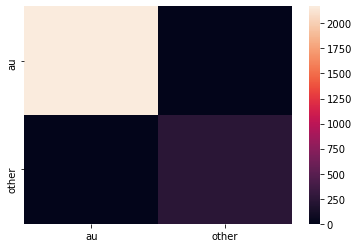

In [ ]:
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)), xticklabels=labels, yticklabels=labels)